In [9]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [30]:
path1='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0731.csv'
df_raw=pd.read_csv(path1)
df_raw.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,mean_ta,gap_ta,min_tafeel,max_tafeel,mean_tafeel,gap_tafeel,min_hm,max_hm,mean_hm,gap_hm,min_wbtemp,max_wbtemp,mean_wbtemp,gap_wbtemp,min_ws,max_ws,mean_ws,tropical_3days,heatwave_temp,heatalert_temp,ta_min_3days,ta_max_3days,gap_ta_minmax,popular_man,popular_woman,agriculture_man,agriculture_woman,ta_min_am,ta_max_am,ta_mean_am,ta_min_pm,ta_max_pm,ta_mean_pm,ta_min_six_am1,ta_max_six_am1,ta_mean_six_am1,ta_min_six_am2,ta_max_six_am2,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,16.6,14.6,12.35,22.04,17.0,9.7,30.0,98.0,61.1,5.4,8.8,14.2,11.6,5.4,0.3,3.5,1.7,0,0,0,9.6,24.2,14.6,6219813,6138017,186278,188594,9,21,13,14,24,20,9.0,13.0,10.0,9,21,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,17.1,13.2,12.78,22.16,17.5,9.4,33.0,91.0,60.0,5.6,9.3,14.9,12.0,5.6,0.0,3.7,1.6,0,0,0,10.5,23.7,13.2,796141,782792,92687,95065,10,21,14,15,23,20,10.0,14.0,12.0,10,21,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


###  MODELING

#### 1. create_date sorting 적용 케이스

In [31]:
# create_date에 대한 sorting 적용
df_raw['create_date'] = pd.to_datetime(df_raw['create_date'])
df_raw.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df_raw = df_raw.fillna(0)

In [32]:
features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
       'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
       'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2',
       'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

48


In [33]:
# 데이터 스케일링
scaler = StandardScaler()
df_raw[features]=scaler.fit_transform(df_raw[features])

# 입력 시퀀스 준비 함수
def create_sequences(data, features, target, sequence_length):
    X = []
    y = []
    dates = []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:i+sequence_length].values)
        y.append(data[target].iloc[i+sequence_length])
        dates.append(data['create_date'].iloc[i+sequence_length])
    return np.array(X), np.array(y), np.array(dates)

In [34]:
sequence_length = 10
X, y, dates = create_sequences(df_raw, features, target, sequence_length)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, dates, test_size=0.2, random_state=20, shuffle=False)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20800, 10, 48)
X_test shape: (5200, 10, 48)
y_train shape: (20800,)
y_test shape: (5200,)


#### 1-1. RNN Modeling

In [35]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

In [36]:
# RNN 모델
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, len(features))))
rnn_model.add(Dense(1))
# 모델 compile
rnn_model.compile(optimizer='adam', loss='mse')

# 학습 모델
rnn_history = rnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# 모델 평가
rnn_loss = rnn_model.evaluate(X_test, y_test)

# 예측값 생성
rnn_predictions = rnn_model.predict(X_test)

# 평가지표
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_r2 = r2_score(y_test, rnn_predictions)

print('RNN Test MAE:', rnn_mae)
print('RNN Test Loss:', rnn_loss)
print('RNN Test MSE:', rnn_mse)
print('RNN Test R^2:', rnn_r2)

Epoch 1/50
650/650 [==============================] - 2s 2ms/step - loss: 3.8225 - val_loss: 3.7590
Epoch 2/50
650/650 [==============================] - 1s 1ms/step - loss: 3.5803 - val_loss: 3.4243
Epoch 3/50
650/650 [==============================] - 1s 1ms/step - loss: 3.4316 - val_loss: 3.7278
Epoch 4/50
650/650 [==============================] - 1s 1ms/step - loss: 3.3205 - val_loss: 3.9353
Epoch 5/50
650/650 [==============================] - 1s 2ms/step - loss: 3.2902 - val_loss: 4.0624
Epoch 6/50
650/650 [==============================] - 1s 2ms/step - loss: 3.0826 - val_loss: 3.4101
Epoch 7/50
650/650 [==============================] - 1s 1ms/step - loss: 3.0138 - val_loss: 3.5803
Epoch 8/50
650/650 [==============================] - 1s 1ms/step - loss: 2.8839 - val_loss: 3.5428
Epoch 9/50
650/650 [==============================] - 1s 1ms/step - loss: 2.8462 - val_loss: 3.4600
Epoch 10/50
650/650 [==============================] - 1s 2ms/step - loss: 2.6368 - val_loss: 3.5245

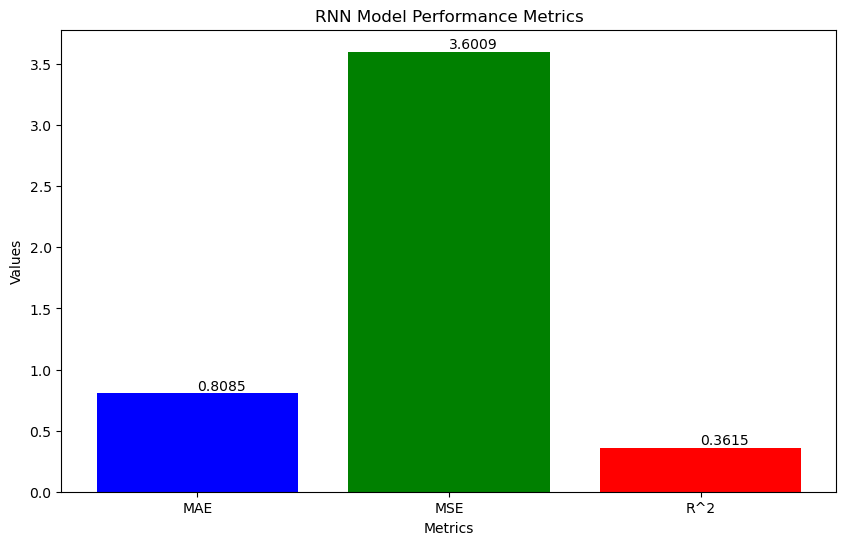

In [10]:
# 성능 평가 지표를 리스트로 정리
metrics = ['MAE', 'MSE', 'R^2']
values = [rnn_mae, rnn_mse, rnn_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RNN Model Performance Metrics')
plt.show()

#### 1-2. LSTM Modeling

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [13]:
# LSTM 모델 빌드
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(features))))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# LSTM 모델 학습
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# LSTM 모델 평가
lstm_loss = lstm_model.evaluate(X_test, y_test)
print('LSTM Test Loss:', lstm_loss)

# 예측값 생성
lstm_predictions = lstm_model.predict(X_test)

# 추가 평가 지표
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)

print('RNN Test MAE:', lstm_mae)
print('RNN Test MSE:', lstm_mse)
print('RNN Test R^2:', lstm_r2)

Epoch 1/50
650/650 [==============================] - 2s 2ms/step - loss: 3.7047 - val_loss: 3.6826
Epoch 2/50
650/650 [==============================] - 1s 2ms/step - loss: 3.5393 - val_loss: 3.5033
Epoch 3/50
650/650 [==============================] - 1s 2ms/step - loss: 3.4344 - val_loss: 3.4143
Epoch 4/50
650/650 [==============================] - 1s 2ms/step - loss: 3.2898 - val_loss: 3.3028
Epoch 5/50
650/650 [==============================] - 1s 2ms/step - loss: 3.2267 - val_loss: 3.1346
Epoch 6/50
650/650 [==============================] - 1s 2ms/step - loss: 3.0571 - val_loss: 3.4013
Epoch 7/50
650/650 [==============================] - 1s 2ms/step - loss: 3.0081 - val_loss: 3.3602
Epoch 8/50
650/650 [==============================] - 1s 2ms/step - loss: 2.9627 - val_loss: 3.1593
Epoch 9/50
650/650 [==============================] - 1s 2ms/step - loss: 2.8073 - val_loss: 3.0002
Epoch 10/50
650/650 [==============================] - 1s 2ms/step - loss: 2.7548 - val_loss: 3.3588

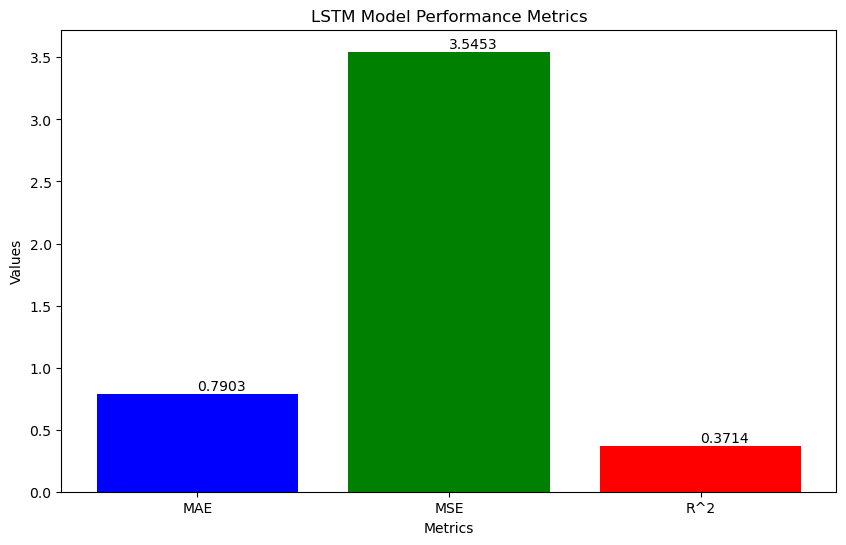

In [14]:
# 성능 평가 지표를 리스트로 정리
metrics = ['MAE', 'MSE', 'R^2']
values = [lstm_mae, lstm_mse, lstm_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('LSTM Model Performance Metrics')
plt.show()

#### 1-3. RandomForest Modeling

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [16]:
# randomforest, xgboost는 flatten 과정 필요
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [20]:
# RF 모델 빌드
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)

# RF 모델
rf_predictions = rf_model.predict(X_test_flat)

# 추가 평가지표 계산
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print('RandomForest Test MAE:', rf_mae)
print('RandomForest Test MSE:', rf_mse)
print('RandomForest Test R^2:', rf_r2)

RandomForest Test MAE: 0.8208192307692308
RandomForest Test MSE: 3.7053154999999998
RandomForest Test R^2: 0.3430139854620733


#### 1-4. XGBoostRegressor Modeling

In [21]:
from xgboost import XGBRegressor

In [22]:
# XGBoost 모델 빌드
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_flat, y_train)

# XGBoost 모델
xgb_predictions = xgb_model.predict(X_test_flat)
xgb_mse = mean_squared_error(y_test, xgb_predictions)

# 추가 평가지표 계산
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print('XGBoost Test MAE:', xgb_mae)
print('XGBoost Test MSE:', xgb_mse)
print('XGBoost Test R^2:', xgb_r2)

XGBoost Test MAE: 0.7634369115122424
XGBoost Test MSE: 3.3701006934929487
XGBoost Test R^2: 0.4024506082654944


#### 1-5. 시각화로 나타내기

#### 실제값과 모델별 예측값 확인하기

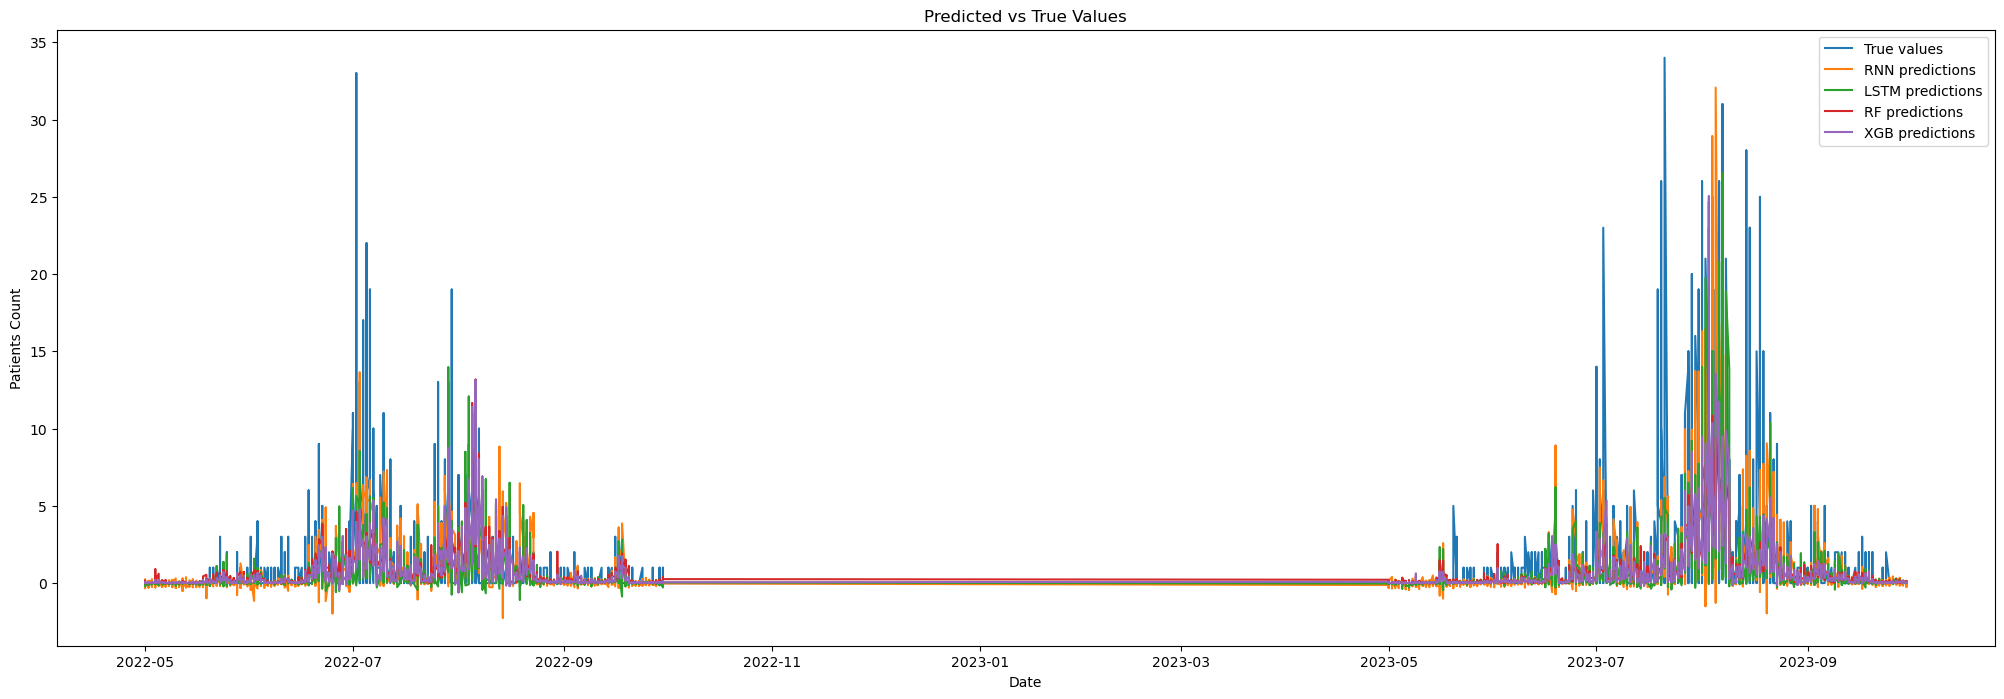

In [38]:
# 결과 시각화
plt.figure(figsize=(25, 8))
plt.plot(dates_test, y_test, label='True values')
plt.plot(dates_test, rnn_predictions, label='RNN predictions')
plt.plot(dates_test, lstm_predictions, label='LSTM predictions')
plt.plot(dates_test, rf_predictions, label='RF predictions')
plt.plot(dates_test, xgb_predictions, label='XGB predictions')
plt.xlabel('Date')
plt.ylabel('Patients Count')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()

In [ ]:
# 성능 평가 지표를 리스트로 정리
metrics = ['MAE', 'MSE', 'R^2']
rnn_values = [rnn_mae, rnn_mse, rnn_r2]
lstm_values = [lstm_mae, lstm_mse, lstm_r2]
rf_values = [rf_mae, rf_mse, rf_r2]
xgb_values = [xgb_mae, xgb_mse, xgb_r2]

# 시각화
x = np.arange(len(metrics))  # 각 지표에 대한 레이블 위치
width = 0.2  # 막대 너비

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5 * width, rnn_values, width, label='RNN', color='blue')
bars2 = ax.bar(x - 0.5 * width, lstm_values, width, label='LSTM', color='green')
bars3 = ax.bar(x + 0.5 * width, rf_values, width, label='RF', color='yellow')
bars4 = ax.bar(x + 1.5 * width, xgb_values, width, label='XGB', color='orange')

# 막대 그래프에 값 표시
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# 레이블 및 제목 설정
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Prediction Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.savefig('Prediction Model Performance Metrics.png')
plt.show()

#### 2. create_date sorting / feature selection 적용 케이스

- feature selection 목록은 SelectKBest에서 추출한 15개 feature 정보로 테스트함

In [39]:
path1='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0731.csv'
df_raw=pd.read_csv(path1)
df_raw.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,mean_ta,gap_ta,min_tafeel,max_tafeel,mean_tafeel,gap_tafeel,min_hm,max_hm,mean_hm,gap_hm,min_wbtemp,max_wbtemp,mean_wbtemp,gap_wbtemp,min_ws,max_ws,mean_ws,tropical_3days,heatwave_temp,heatalert_temp,ta_min_3days,ta_max_3days,gap_ta_minmax,popular_man,popular_woman,agriculture_man,agriculture_woman,ta_min_am,ta_max_am,ta_mean_am,ta_min_pm,ta_max_pm,ta_mean_pm,ta_min_six_am1,ta_max_six_am1,ta_mean_six_am1,ta_min_six_am2,ta_max_six_am2,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,16.6,14.6,12.35,22.04,17.0,9.7,30.0,98.0,61.1,5.4,8.8,14.2,11.6,5.4,0.3,3.5,1.7,0,0,0,9.6,24.2,14.6,6219813,6138017,186278,188594,9,21,13,14,24,20,9.0,13.0,10.0,9,21,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,17.1,13.2,12.78,22.16,17.5,9.4,33.0,91.0,60.0,5.6,9.3,14.9,12.0,5.6,0.0,3.7,1.6,0,0,0,10.5,23.7,13.2,796141,782792,92687,95065,10,21,14,15,23,20,10.0,14.0,12.0,10,21,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


In [40]:
# create_date에 대한 sorting 적용
df_raw['create_date'] = pd.to_datetime(df_raw['create_date'])
df_raw.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df_raw = df_raw.fillna(0)

In [41]:
features=['max_ta', 'mean_ta', 'max_tafeel', 'mean_tafeel', 'ta_max_am', 'ta_mean_am', 'ta_max_pm', 'ta_mean_pm', 'ta_max_six_am2',
     'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

15


In [42]:
# 데이터 스케일링
scaler = StandardScaler()
df_raw[features]=scaler.fit_transform(df_raw[features])

# 입력 시퀀스 준비 함수
def create_sequences(data, features, target, sequence_length):
    X = []
    y = []
    dates = []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:i+sequence_length].values)
        y.append(data[target].iloc[i+sequence_length])
        dates.append(data['create_date'].iloc[i+sequence_length])
    return np.array(X), np.array(y), np.array(dates)

In [43]:
sequence_length = 10
X, y, dates = create_sequences(df_raw, features, target, sequence_length)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, dates, test_size=0.2, random_state=20, shuffle=False)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20800, 10, 15)
X_test shape: (5200, 10, 15)
y_train shape: (20800,)
y_test shape: (5200,)


#### 2-1. RNN Modeling

In [44]:
# RNN 모델
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, len(features))))
rnn_model.add(Dense(1))
# 모델 compile
rnn_model.compile(optimizer='adam', loss='mse')

# 학습 모델
rnn_history = rnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# 모델 평가
rnn_loss = rnn_model.evaluate(X_test, y_test)

# 예측값 생성
rnn_predictions = rnn_model.predict(X_test)

# 평가지표
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_r2 = r2_score(y_test, rnn_predictions)

print('RNN Test MAE:', rnn_mae)
print('RNN Test Loss:', rnn_loss)
print('RNN Test MSE:', rnn_mse)
print('RNN Test R^2:', rnn_r2)

Epoch 1/50
650/650 [==============================] - 2s 2ms/step - loss: 4.0173 - val_loss: 3.9348
Epoch 2/50
650/650 [==============================] - 1s 1ms/step - loss: 3.9928 - val_loss: 4.3801
Epoch 3/50
650/650 [==============================] - 1s 1ms/step - loss: 3.9372 - val_loss: 4.0035
Epoch 4/50
650/650 [==============================] - 1s 1ms/step - loss: 3.8478 - val_loss: 4.1151
Epoch 5/50
650/650 [==============================] - 1s 1ms/step - loss: 3.8293 - val_loss: 4.2116
Epoch 6/50
650/650 [==============================] - 1s 1ms/step - loss: 3.8522 - val_loss: 3.8800
Epoch 7/50
650/650 [==============================] - 1s 1ms/step - loss: 3.8134 - val_loss: 4.0281
Epoch 8/50
650/650 [==============================] - 1s 1ms/step - loss: 3.7483 - val_loss: 3.8986
Epoch 9/50
650/650 [==============================] - 1s 1ms/step - loss: 3.7961 - val_loss: 4.2306
Epoch 10/50
650/650 [==============================] - 1s 1ms/step - loss: 3.7051 - val_loss: 3.7753

#### 2-2. LSTM Modeling

In [45]:
# LSTM 모델 빌드
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(features))))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# LSTM 모델 학습
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# LSTM 모델 평가
lstm_loss = lstm_model.evaluate(X_test, y_test)
print('LSTM Test Loss:', lstm_loss)

# 예측값
lstm_predictions = lstm_model.predict(X_test)

# 평가지표
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)

print('RNN Test MAE:', lstm_mae)
print('RNN Test MSE:', lstm_mse)
print('RNN Test R^2:', lstm_r2)

Epoch 1/50
650/650 [==============================] - 2s 2ms/step - loss: 3.8054 - val_loss: 4.0717
Epoch 2/50
650/650 [==============================] - 2s 2ms/step - loss: 3.6924 - val_loss: 3.8703
Epoch 3/50
650/650 [==============================] - 1s 2ms/step - loss: 3.7340 - val_loss: 3.9651
Epoch 4/50
650/650 [==============================] - 1s 2ms/step - loss: 3.6519 - val_loss: 3.9722
Epoch 5/50
650/650 [==============================] - 1s 2ms/step - loss: 3.6600 - val_loss: 3.9214
Epoch 6/50
650/650 [==============================] - 1s 2ms/step - loss: 3.6696 - val_loss: 3.9420
Epoch 7/50
650/650 [==============================] - 1s 2ms/step - loss: 3.6075 - val_loss: 3.8962
Epoch 8/50
650/650 [==============================] - 1s 2ms/step - loss: 3.6085 - val_loss: 3.8335
Epoch 9/50
650/650 [==============================] - 1s 2ms/step - loss: 3.6116 - val_loss: 3.8713
Epoch 10/50
650/650 [==============================] - 2s 2ms/step - loss: 3.6275 - val_loss: 3.8393

#### 2-3. RandomForest Modeling

In [46]:
# randomforest, xgboost는 flatten 과정 필요
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# RF 모델 빌드
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)

# RF 평가 지표
rf_predictions = rf_model.predict(X_test_flat)
rf_mse = mean_squared_error(y_test, rf_predictions)
print('RandomForest Test MSE:', rf_mse)

# 추가 평가 지표 
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print('RandomForest Test MAE:', rf_mae)
print('RandomForest Test MSE:', rf_mse)
print('RandomForest Test R^2:', rf_r2)

RandomForest Test MSE: 4.10682701923077
RandomForest Test MAE: 0.8573634615384615
RandomForest Test MSE: 4.10682701923077
RandomForest Test R^2: 0.27182235473305927


#### 2-4. XGBoost Regressor Modeling

In [47]:
# XGBoost 모델 빌드
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_flat, y_train)

# XGBoost 모델
xgb_predictions = xgb_model.predict(X_test_flat)
xgb_mse = mean_squared_error(y_test, xgb_predictions)

# 추가 평가지표 계산
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print('XGBoost Test MAE:', xgb_mae)
print('XGBoost Test MSE:', xgb_mse)
print('XGBoost Test R^2:', xgb_r2)

XGBoost Test MAE: 0.8106102712592558
XGBoost Test MSE: 3.931569094293962
XGBoost Test R^2: 0.30289717295580454


#### 2-5. RNN, LSTM, RandomForest, XGBoost 평가지표 시각화

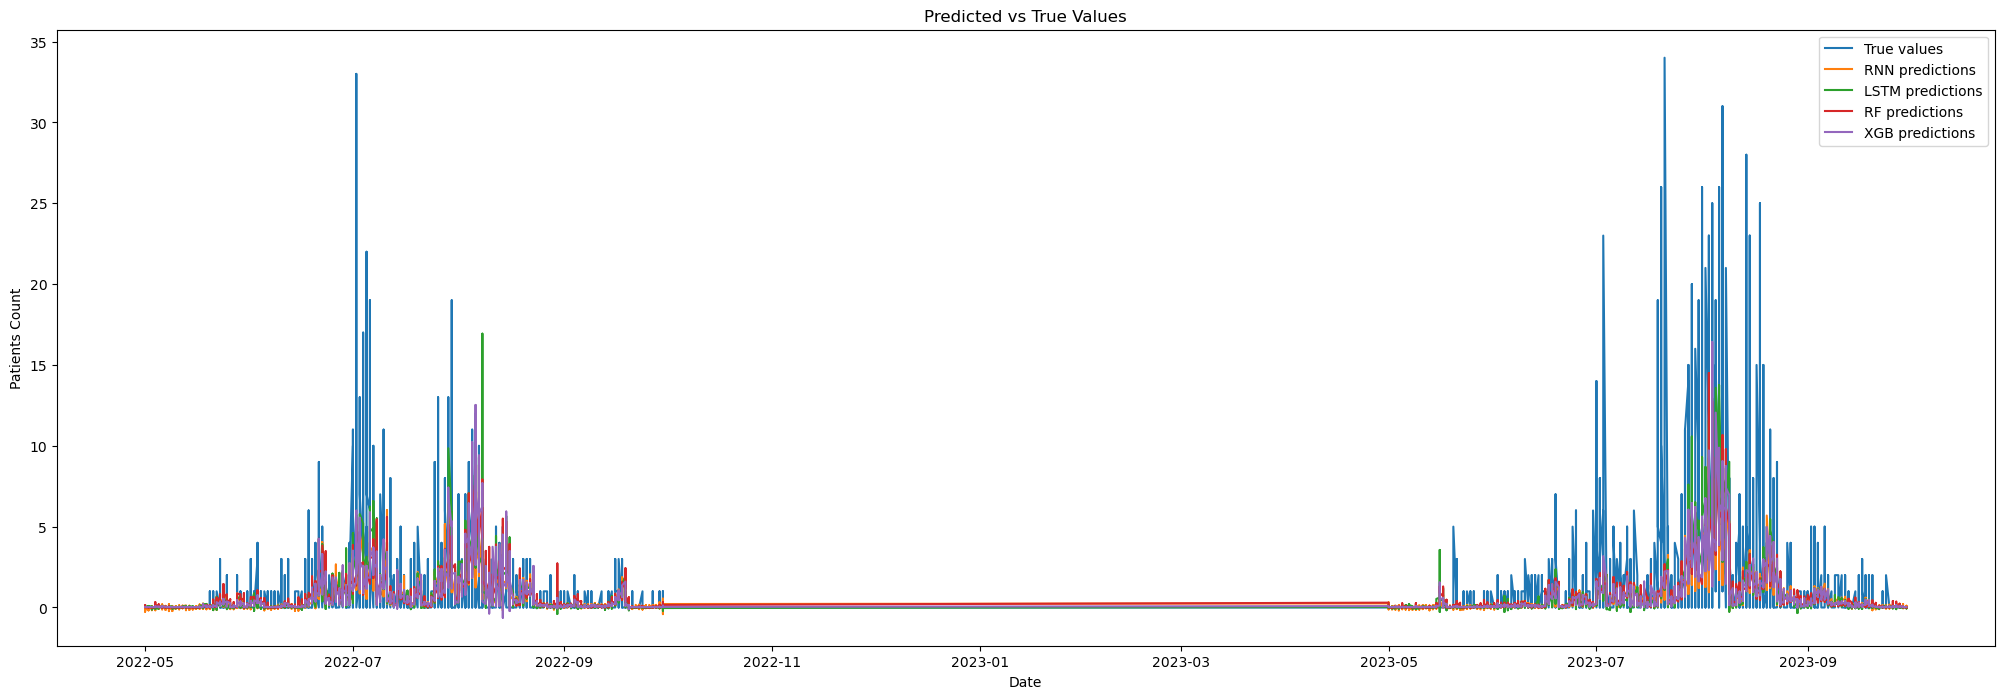

In [49]:
# 결과 시각화
plt.figure(figsize=(25, 8))
plt.plot(dates_test, y_test, label='True values')
plt.plot(dates_test, rnn_predictions, label='RNN predictions')
plt.plot(dates_test, lstm_predictions, label='LSTM predictions')
plt.plot(dates_test, rf_predictions, label='RF predictions')
plt.plot(dates_test, xgb_predictions, label='XGB predictions')
plt.xlabel('Date')
plt.ylabel('Patients Count')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()

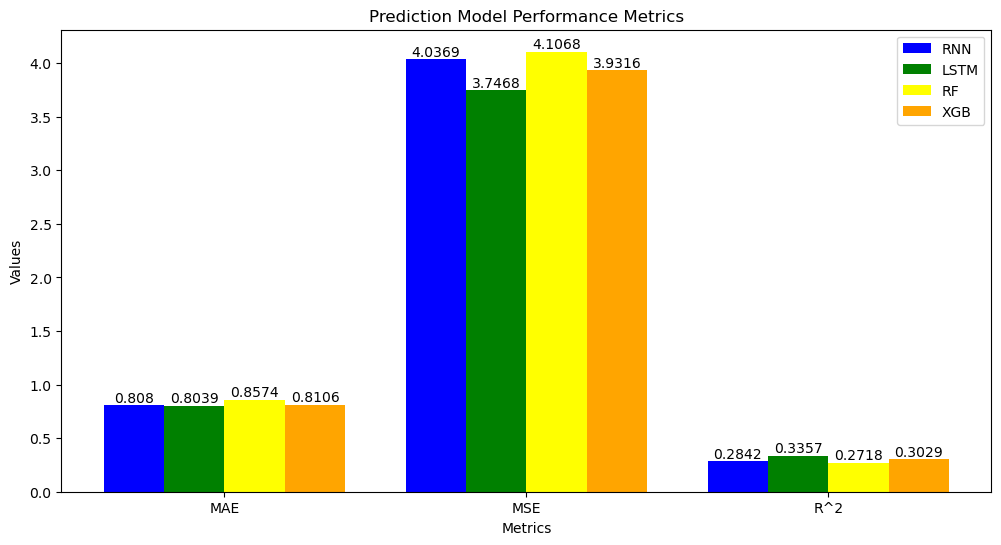

In [48]:
# 성능 평가 지표를 리스트로 정리
metrics = ['MAE', 'MSE', 'R^2']
rnn_values = [rnn_mae, rnn_mse, rnn_r2]
lstm_values = [lstm_mae, lstm_mse, lstm_r2]
rf_values = [rf_mae, rf_mse, rf_r2]
xgb_values = [xgb_mae, xgb_mse, xgb_r2]

# 시각화
x = np.arange(len(metrics))  # 각 지표에 대한 레이블 위치
width = 0.2  # 막대 너비

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5 * width, rnn_values, width, label='RNN', color='blue')
bars2 = ax.bar(x - 0.5 * width, lstm_values, width, label='LSTM', color='green')
bars3 = ax.bar(x + 0.5 * width, rf_values, width, label='RF', color='yellow')
bars4 = ax.bar(x + 1.5 * width, xgb_values, width, label='XGB', color='orange')

# 막대 그래프에 값 표시
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# 레이블 및 제목 설정
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Prediction Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.savefig('Prediction Model Performance Metrics.png')
plt.show()

#### 3. create_date 적용 케이스 (date sorting X)

In [52]:
path1='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0731.csv'
df_raw=pd.read_csv(path1)
df_raw.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,mean_ta,gap_ta,min_tafeel,max_tafeel,mean_tafeel,gap_tafeel,min_hm,max_hm,mean_hm,gap_hm,min_wbtemp,max_wbtemp,mean_wbtemp,gap_wbtemp,min_ws,max_ws,mean_ws,tropical_3days,heatwave_temp,heatalert_temp,ta_min_3days,ta_max_3days,gap_ta_minmax,popular_man,popular_woman,agriculture_man,agriculture_woman,ta_min_am,ta_max_am,ta_mean_am,ta_min_pm,ta_max_pm,ta_mean_pm,ta_min_six_am1,ta_max_six_am1,ta_mean_six_am1,ta_min_six_am2,ta_max_six_am2,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,16.6,14.6,12.35,22.04,17.0,9.7,30.0,98.0,61.1,5.4,8.8,14.2,11.6,5.4,0.3,3.5,1.7,0,0,0,9.6,24.2,14.6,6219813,6138017,186278,188594,9,21,13,14,24,20,9.0,13.0,10.0,9,21,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,17.1,13.2,12.78,22.16,17.5,9.4,33.0,91.0,60.0,5.6,9.3,14.9,12.0,5.6,0.0,3.7,1.6,0,0,0,10.5,23.7,13.2,796141,782792,92687,95065,10,21,14,15,23,20,10.0,14.0,12.0,10,21,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


In [53]:
# create_date에 대한 sorting 적용
df_raw['create_date'] = pd.to_datetime(df_raw['create_date'])
# 결측치 채우기
df_raw = df_raw.fillna(0)

In [54]:
features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
       'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
       'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2',
       'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'

In [55]:
# Feature와 Target 분리
X = df_raw[features]
y = df_raw[target]
dates = df_raw['create_date']

In [56]:
# 데이터 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 시퀀스 생성 함수
def create_sequences(data, target, dates, sequence_length):
    Xs, ys, date_sequences = [], [], []
    for i in range(len(data) - sequence_length):
        Xs.append(data[i:(i + sequence_length)])
        ys.append(target[i + sequence_length])
        date_sequences.append(dates[i + sequence_length])
    return np.array(Xs), np.array(ys), np.array(date_sequences)

In [58]:
sequence_length = 10
X_sequences, y_sequences, date_sequences = create_sequences(X_scaled, y.values, dates.values, sequence_length)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X_sequences, y_sequences, date_sequences, test_size=0.2, random_state=42)

# RNN 모델 생성 및 학습
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, X_train.shape[2])))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# LSTM 모델 생성 및 학습
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, X_train.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# RF 모델 생성 및 학습
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_flat, y_train)

# XGBoost 모델 생성 및 학습
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
xgb_model = XGBRegressor()
xgb_model.fit(X_train_flat, y_train)

Epoch 1/50
650/650 [==============================] - 2s 2ms/step - loss: 4.2560 - val_loss: 2.9743
Epoch 2/50
650/650 [==============================] - 1s 1ms/step - loss: 3.5301 - val_loss: 2.4066
Epoch 3/50
650/650 [==============================] - 1s 2ms/step - loss: 3.1646 - val_loss: 2.5015
Epoch 4/50
650/650 [==============================] - 1s 1ms/step - loss: 2.8546 - val_loss: 3.9232
Epoch 5/50
650/650 [==============================] - 1s 1ms/step - loss: 3.0873 - val_loss: 2.3521
Epoch 6/50
650/650 [==============================] - 1s 1ms/step - loss: 3.1436 - val_loss: 2.2122
Epoch 7/50
650/650 [==============================] - 1s 1ms/step - loss: 2.8931 - val_loss: 2.8417
Epoch 8/50
650/650 [==============================] - 1s 1ms/step - loss: 3.6384 - val_loss: 2.6197
Epoch 9/50
650/650 [==============================] - 1s 1ms/step - loss: 2.6444 - val_loss: 2.1881
Epoch 10/50
650/650 [==============================] - 1s 1ms/step - loss: 2.9819 - val_loss: 2.1357

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [65]:
# 예측 및 평가
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{model_name} model performance:')
    print(f'MAE: {mae:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'R2: {r2:.4f}')
    return y_pred

# RNN 평가
y_pred_rnn = evaluate_model(rnn_model, X_test, y_test, 'RNN')
# LSTM 평가
y_pred_lstm = evaluate_model(lstm_model, X_test, y_test, 'LSTM')
# RandomForest 평가
y_pred_xgb = evaluate_model(rf_model, X_test_flat, y_test, 'RandomForest')
# XGBoost 평가
y_pred_xgb = evaluate_model(xgb_model, X_test_flat, y_test, 'XGBoost')

163/163 [==============================] - 0s 838us/step
RNN model performance:
MAE: 0.6342
MSE: 2.4163
R2: 0.5171
163/163 [==============================] - 0s 1ms/step
LSTM model performance:
MAE: 0.6250
MSE: 1.8890
R2: 0.6224
RandomForest model performance:
MAE: 0.5739
MSE: 1.5995
R2: 0.6803
XGBoost model performance:
MAE: 0.5766
MSE: 1.6895
R2: 0.6623


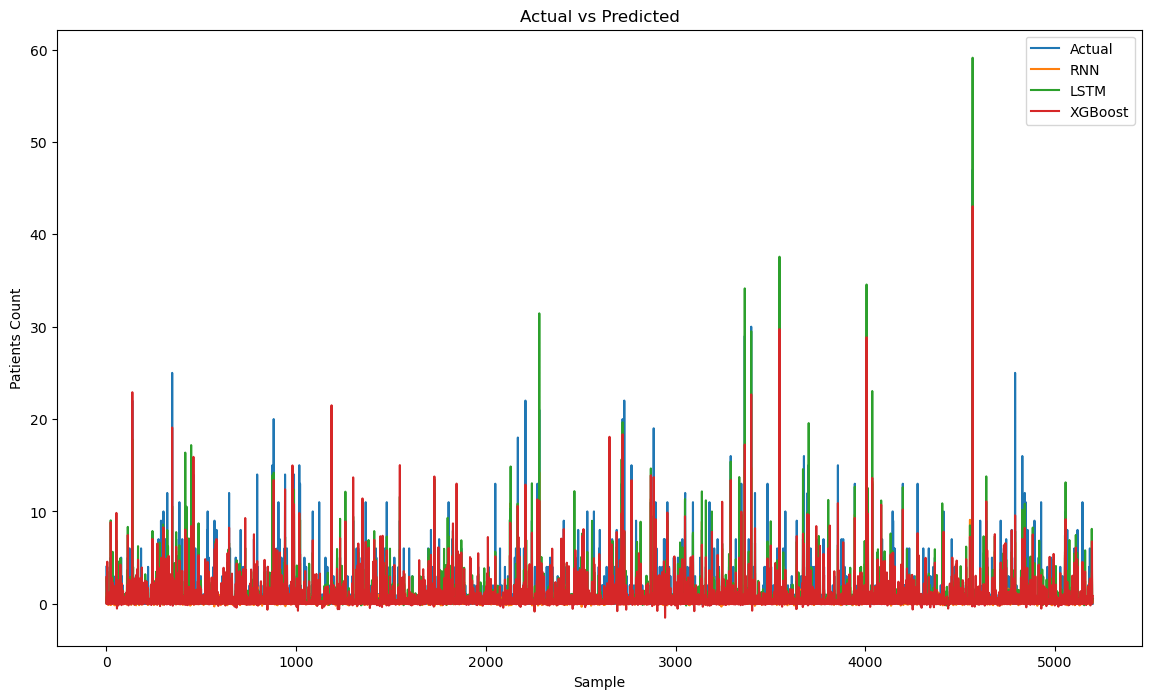

In [62]:
# 결과 시각화
plt.figure(figsize=(14, 8))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_rnn, label='RNN')
plt.plot(y_pred_lstm, label='LSTM')
plt.plot(y_pred_xgb, label='XGBoost')
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Patients Count')
plt.show()

#### 4. create_date (date sorting X) / feature selection 적용 케이스 